In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
%matplotlib inline

# 导入数据

In [2]:
#读取 voice.csv文件
data = pd.read_csv('voice.csv')

#抽取性别一列作为数据标签
genders_raw = data['label']

#得到只包含各项特征的数据集合
data = data.drop('label', axis=1)

features_raw = data
print("voice datasets has {} data points with {} variables each.".format(*data.shape))

voice datasets has 3168 data points with 20 variables each.


## 按箱形图可视化，观察整体特征

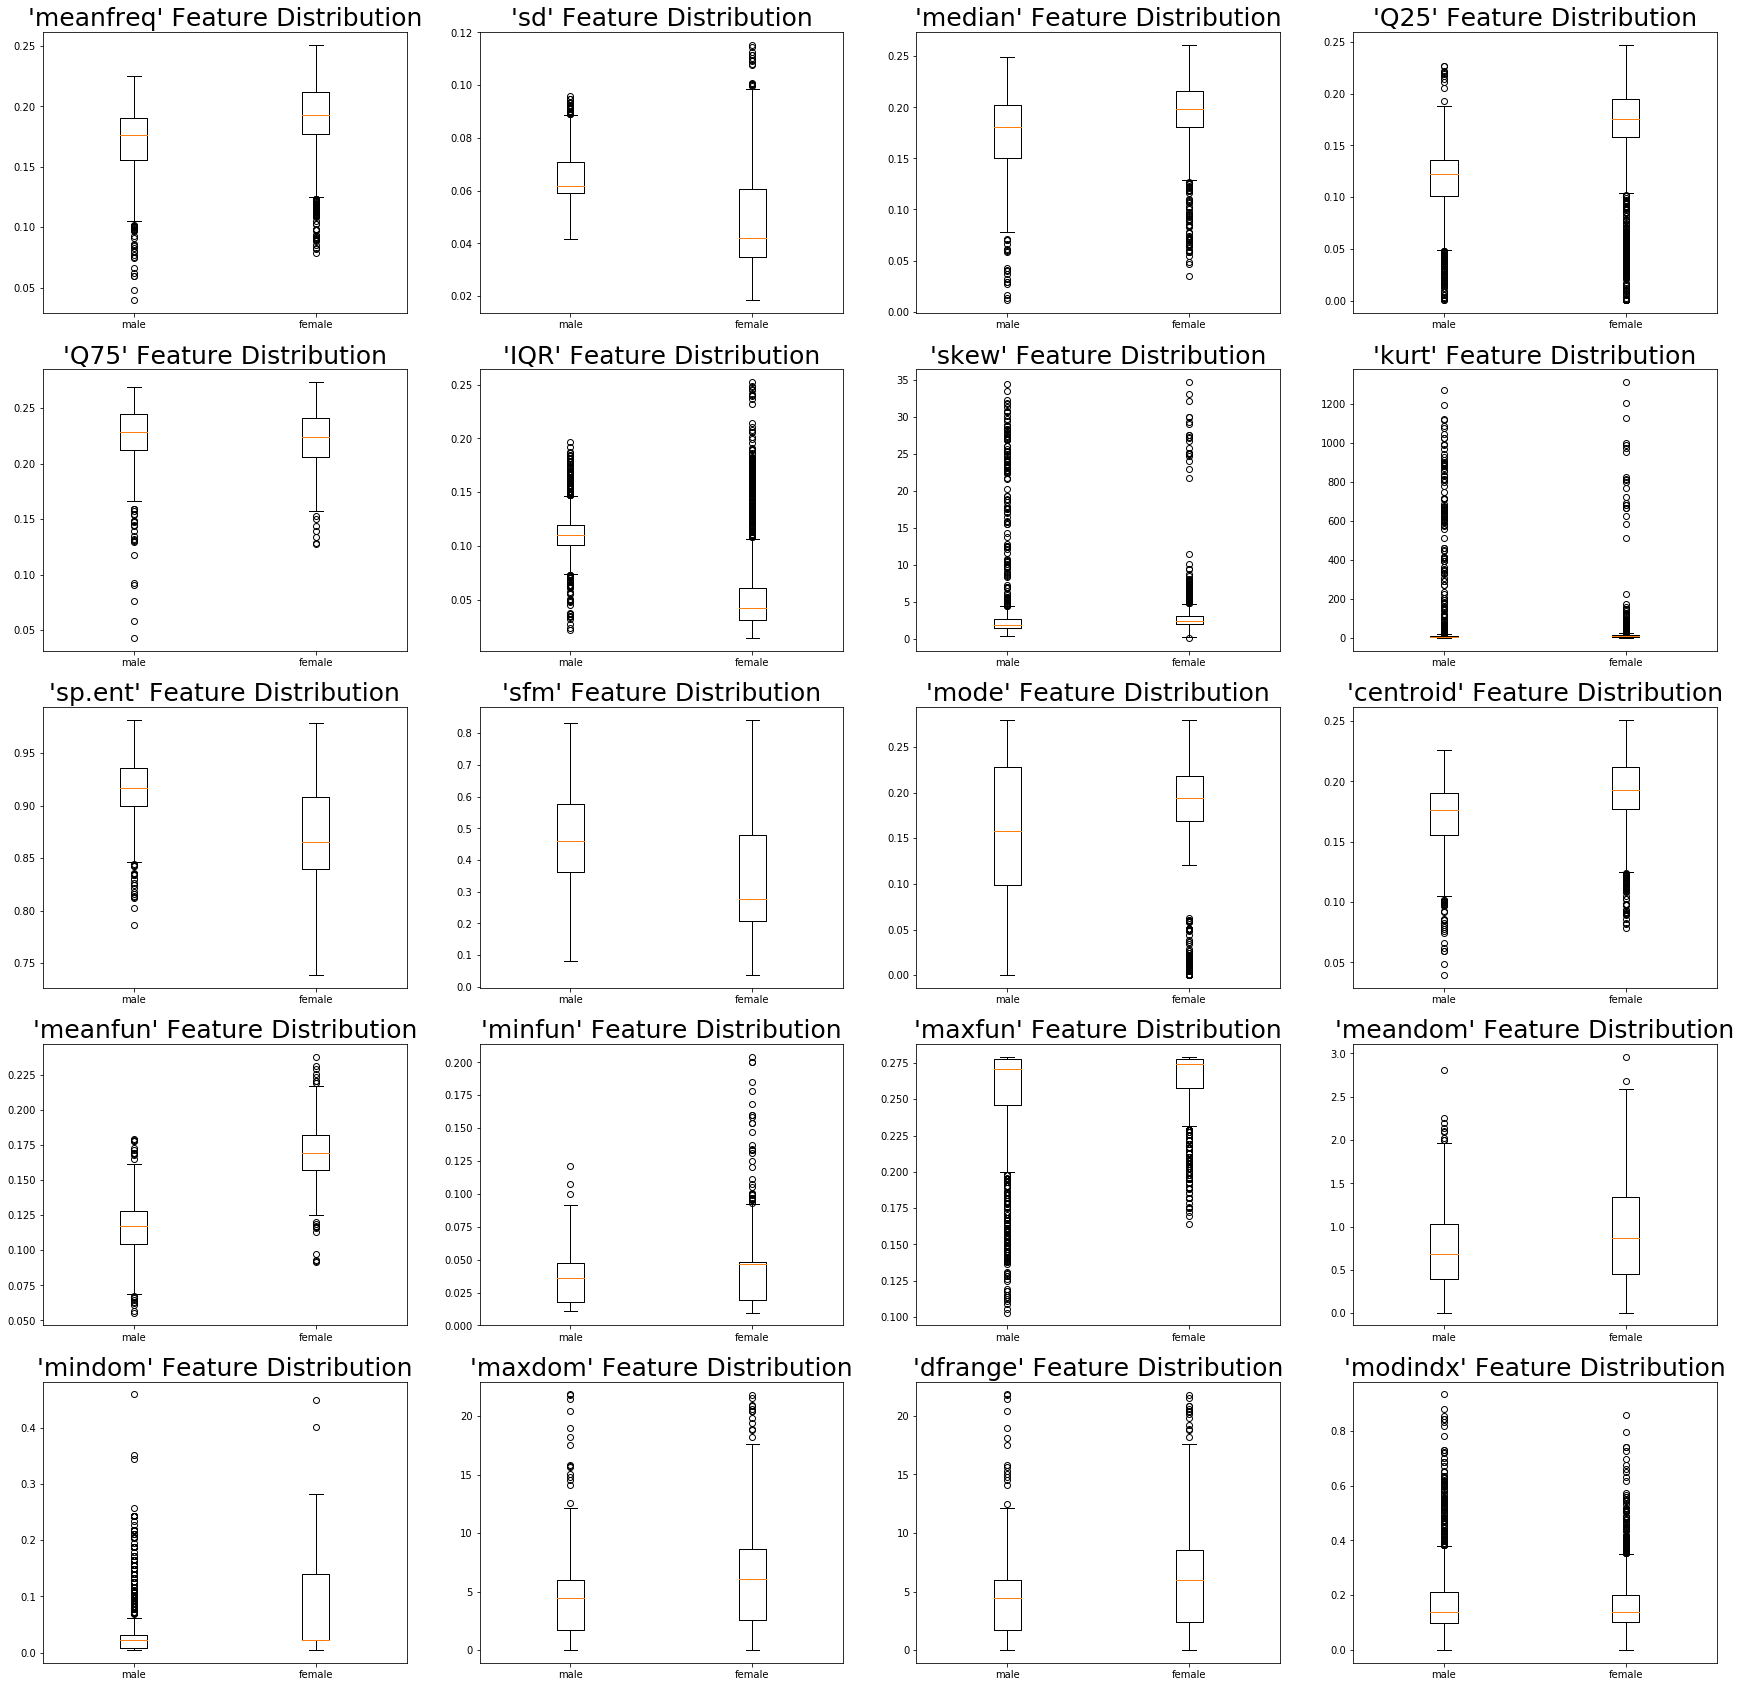

In [3]:
# 特征列表
feature_list = [ 'meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt', 'sp.ent', 'sfm', 
    'mode', 'centroid', 'meanfun', 'minfun', 'maxfun', 'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx' ]

# 定义一个列表，用以存放每一个按特征和性别分类好的pd.DataFrame结构
data_frames = []

#提取每一个特征的值及其索引
for index, value in enumerate(feature_list):
    
    df_male = features_raw[value][0 : 1584]
    df_female = features_raw[value][1584 : 3168]
    df = [ df_male, df_female]
    
    data_frames.append(df)


#创建绘图窗口
fig = pl.figure(figsize = (30,30))

#绘制子图
for index, feature in enumerate(feature_list):
    df = data_frames[index]
    ax = fig.add_subplot(5, 4, index+1)
    ax.boxplot(x=df,labels=['male', 'female'], whis=1.5) 
    ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 25) 

# 标签数值化

In [4]:
#将非数值标签转换成数值参数，male为1，female为0
genders = genders_raw.apply(lambda x: int(x == 'male') )

## 观察是否存在倾斜分布的连续特征

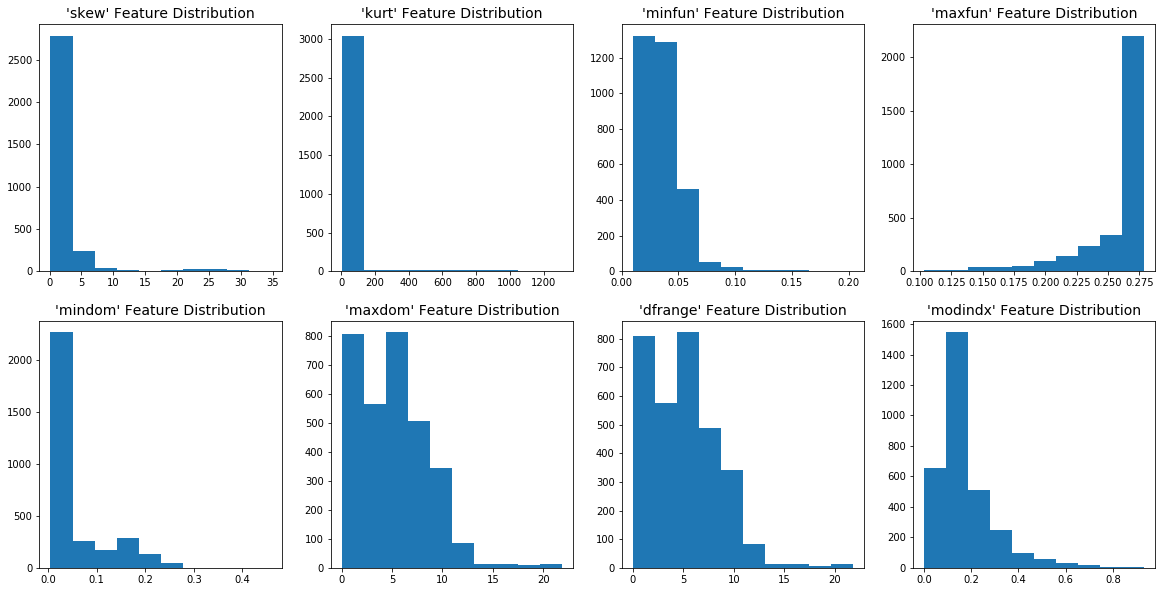

In [5]:
skew_list = ['skew', 'kurt', 'minfun', 'maxfun', 'mindom','maxdom', 'dfrange', 'modindx']
fig = pl.figure(figsize = (20,10))

#分别对上述几项特征的分布进行可视化
for i, feature in enumerate(skew_list):
        ax = fig.add_subplot(2,4,i+1)
        ax.hist(data[feature])   
        ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
        

## 对数转换后再次观察skew_list中的特征分布

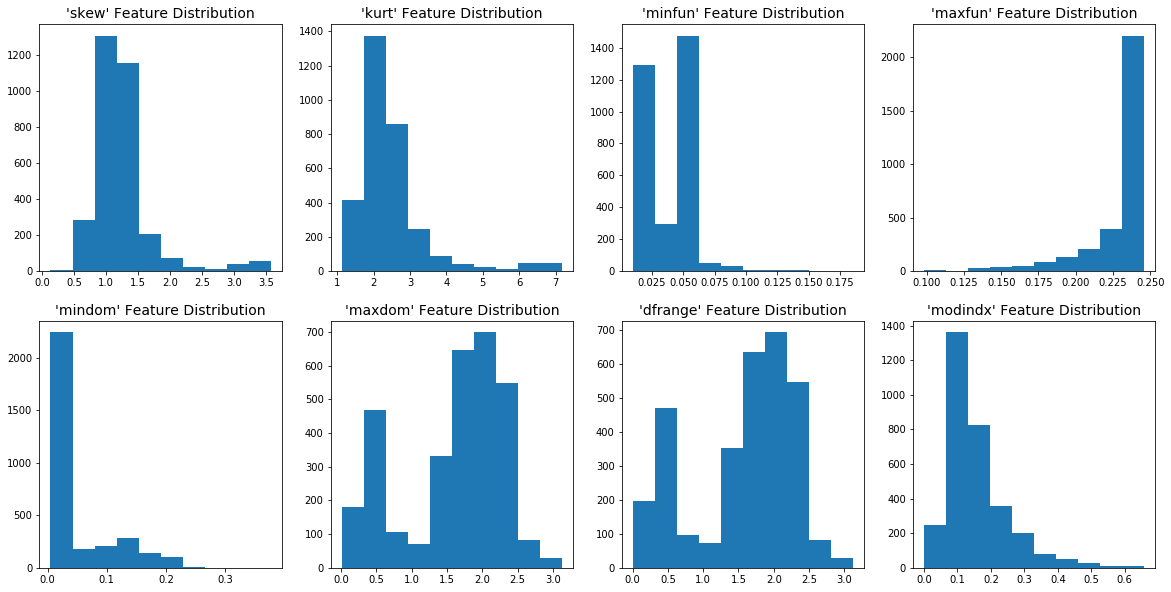

In [6]:
#对倾斜分布的几项特征进行非线性变换-log
features_raw[skew_list] = data[skew_list].apply(lambda x: np.log(x + 1))

fig = pl.figure(figsize = (20,10))

#再次可视化
for i, feature in enumerate(skew_list):
        ax = fig.add_subplot(2,4,i+1)
        ax.hist(features_raw[feature])   
        ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14) 

## 移除无效特征

In [7]:
#将skew，kurt两特征移除
drop_list = ['skew', 'kurt',]

features_drop = features_raw.drop(drop_list, axis=1)

## 归一化特征

In [8]:
#对各项特征进行归一化
from sklearn.preprocessing import MinMaxScaler

#initialize a scaler, and implement it on features_raw
scaler = MinMaxScaler()
features = scaler.fit_transform(features_drop)

# 分离：训练集/测试集

In [9]:
from sklearn.model_selection import train_test_split

#分离训练集，验证集，测试集
x_train, x_test, y_train, y_test = train_test_split(features, genders, test_size=0.2, random_state=40)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=40)

print("Training set has {} samples.".format(x_train.shape[0]))
print("Val set has {} samples.".format(x_val.shape[0]))
print("Testing set has {} samples.".format(x_test.shape[0]))

Training set has 2027 samples.
Val set has 507 samples.
Testing set has 634 samples.


# 创建一个训练和预测的流水线

In [10]:
from sklearn.metrics import fbeta_score, accuracy_score
from time import time

def train_predict(learner, data_train, labels_train, data_test, labels_test):
        
    #训练分类器，并计算训练用时
    start_time = time()
    learner = learner.fit(data_train, labels_train)
    end_time = time()
    print('Training_time: ', end_time - start_time)
    
    #在训练集上预测, 并打印准确率
    predictions_train = learner.predict(data_train)
    print('Accuracy_train:  ', accuracy_score(labels_train, predictions_train))

    #在测试集上预测，并打印准确率
    predictions_test = learner.predict(data_test)
    print('Accuracy_test:  ', accuracy_score(labels_test, predictions_test))
    
    return 

## Try:  RandomForest 未调参的基本模型

In [11]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state = 20)

train_predict(learner=clf, data_train=x_train, 
              labels_train=y_train, data_test=x_test, labels_test=y_test)



Training_time:  0.06901717185974121
Accuracy_train:   0.997039960533
Accuracy_test:   0.970031545741


## Cross Validation-RandomForest

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

#创建一个accuracy_score打分对象
def performance_metric(y_true, y_predict):
    
    score = accuracy_score(y_true, y_predict)
    
    return score


#初始化分类器
clf = RandomForestClassifier(oob_score=False, random_state=40, n_jobs=-1)

#经过分别尝试后，最终的各项最优参数
parameters = { 'n_estimators':[70,80,2], 'criterion':['gini','entropy'],
               'max_depth':range(10,20,2), 'max_features':['auto']}

#评分函数
scorer = make_scorer(score_func=performance_metric)

#建立网格搜索
grid_obj = GridSearchCV(estimator=clf, param_grid=parameters, scoring=scorer)

#开始网格搜索，计算并打印训练时长
start = time()
grid_obj = grid_obj.fit(x_train, y_train)
end = time()
print('Training time： ', end-start)

#获得最优模型
best_clf = grid_obj.best_estimator_

#获取在训练集上的准确率
predictions_train = best_clf.predict(x_train)
accuracy_train = accuracy_score(y_train, predictions_train)
print('Accuracy_train: ', accuracy_train)

#获取在验证集上的准确率
predictions_val = best_clf.predict(x_val)
accuracy_val = accuracy_score(y_val, predictions_val)
print('Accuracy_val:   ', accuracy_val)

#获得各项最优参数
print('\ncurrent_best_params:\n',grid_obj.best_params_)

#打印袋外得分，用以辅助分析
#print('\noob_score_: ', best_clf.oob_score_)

Training time：  39.52200222015381
Accuracy_train:  1.0
Accuracy_val:    0.980276134122

current_best_params:
 {'criterion': 'gini', 'max_depth': 14, 'max_features': 'auto', 'n_estimators': 80}


## 最优模型在测试集上的准确率

In [35]:
#得到最优模型在测试集上的表现
predictions_test = best_clf.predict(x_test)

accuracy_test = accuracy_score(y_test, predictions_test)

print('Accuracy_test:   ', accuracy_test)

Accuracy_test:    0.981072555205


## 加入测试噪音

Text(0,0.5,'current global accuracy')

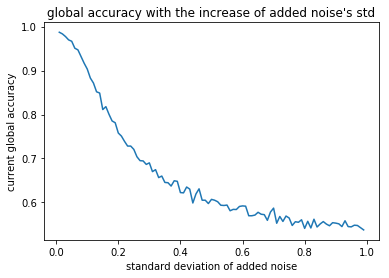

In [36]:
#生成标准差序列1~100
scale_range = list( range(1,100,1) )

#初始化空列表，用以存放高斯噪声的标准差及其对应的准确率
accuracy_in_noise = []
std_s = []

#遍历不同std
for scale in scale_range:
    
    #将该数值缩小100倍，作为生成高斯噪声的标准差
    standard_deviation = float(scale) / 100
    
    #取所有数据的行数和列数
    row, col = features.shape
    #生成同样维度的高斯分布，作为随机噪声
    gaussian_noise = np.random.normal(loc=0, scale=standard_deviation, size=(row, col))
    #将噪音添加到所有的特征数据中
    features_noise = np.add(features, gaussian_noise)

    #将数据带入预测模型，得到准确率
    predictions = best_clf.predict(features_noise)
    accuracy = accuracy_score(genders, predictions)
    
    #添加数列
    accuracy_in_noise.append(accuracy)
    std_s.append(standard_deviation)

#将结果可视化
pl.plot(std_s, accuracy_in_noise)
pl.title("global accuracy with the increase of added noise's std")
pl.xlabel('standard deviation of added noise')
pl.ylabel('current global accuracy')

## 可视化最优模型在测试集上的表现

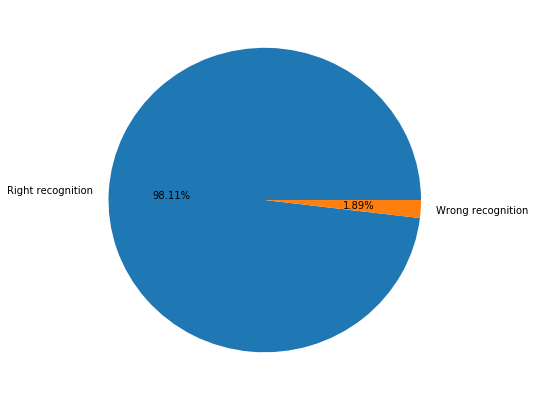

In [37]:
#两类预测结果
results = ['Right recognition', 'Wrong recognition']

#两种情况各自对应的概率
x = [accuracy_test, 1-accuracy_test]

#将上述结果用饼图进行可视化
fig = pl.figure(figsize = (7,7))
pl.pie(x, labels=results, autopct='%1.2f%%')

pl.show()

## 对预测错误数据进行分析

### 提取错误预测点

In [55]:
points_test = len(x_test)

#初始化列表，用以存放预测错误的数据
error_points = []
y_test = list(y_test)

#将分类错误的数据点的各项特征值存入列表
for i in range(points_test):
    point = np.reshape(x_test[i], (-1,18))
    pred = best_clf.predict(point)
    
    if pred != y_test[i]:
        error = x_test[i]
        gender = y_test[i]   
        error_points.append(error)
 

### 统计分类错误的数据点的各特征均值，及完整数据集的对应值

In [56]:
#计算全部数据集上的各项特征的均值，并切分为两部分
means_all = np.mean(features, axis=0)
means_all_1 = means_all[0:9]
means_all_2 = means_all[9:18]

#计算分类错误集上的各项特征的均值，并切分为两部分
means_error = np.mean(error_points, axis=0)
means_error_1 = means_error[0:9]
means_error_2 = means_error[9:18]

#将特征标签名称切分为两部分，用于下文可视化的x轴
feature_list = ['meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'sp.ent', 'sfm', 'mode', 
             'centroid', 'meanfun', 'minfun', 'maxfun', 'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx']

feature_list_1 = feature_list[0:9]
feature_list_2 = feature_list[9:18]

### 分别展示分类错误点的特征各均值和完整数据集的对应特征的均值（前9个特征）

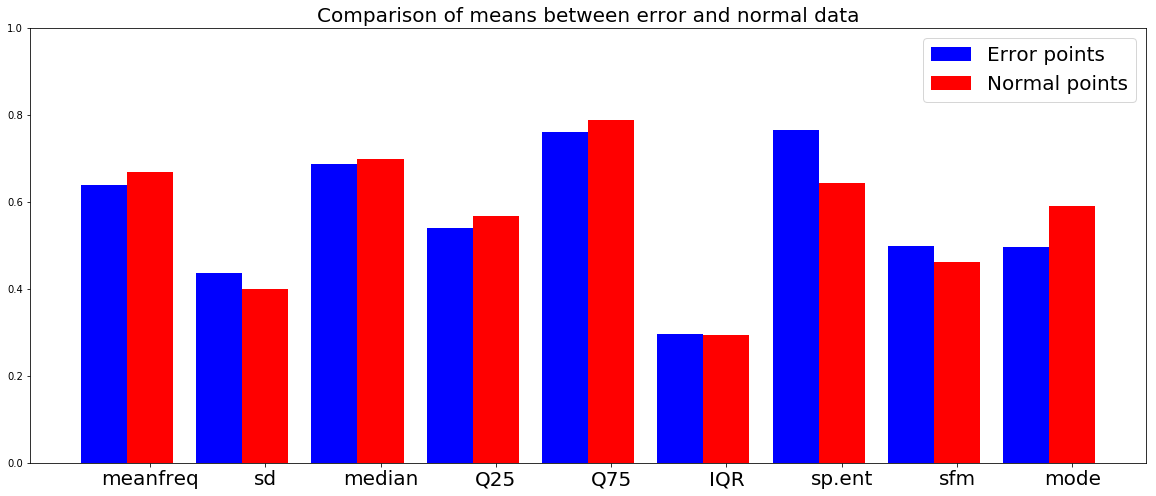

In [57]:
#配置柱状图间隔参数
bar_width = 0.8

#生成x轴的序列
index = np.arange( 0, 2*len(means_all_1), 2)

#初始化窗口大小
fig = pl.figure(figsize = (20,8))

#绘制错误点数据均值的柱状图
rects1 = pl.bar(index, means_error_1, color='blue', label='error_1')
#绘制完整数据集均值的柱状图
rects1 = pl.bar(index+bar_width, means_all_1, color='red', label='error_1')

# 图表标题 
pl.title("Comparison of means between error and normal data", fontsize=20)
# X轴标题 
pl.xticks(index + bar_width, feature_list_1, fontsize=20)
# Y轴范围
pl.ylim(ymax=1, ymin=0)
# 图例
pl.legend(['Error points', 'Normal points'], fontsize=20)

pl.show()

### 分别展示分类错误点的特征各均值和完整数据集的对应特征的均值（后9个特征）

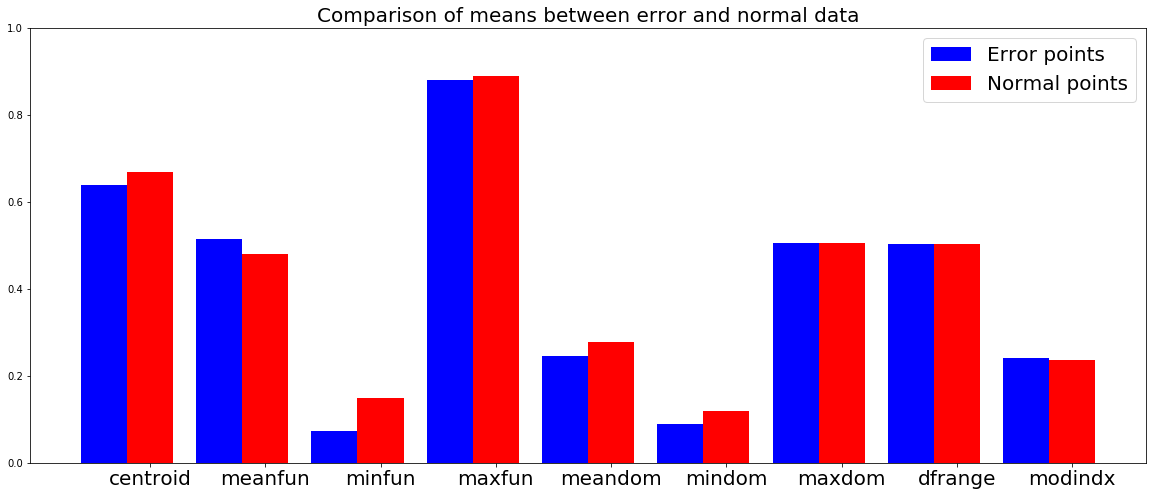

In [58]:
#配置柱状图间隔参数
bar_width = 0.8

#生成x轴的序列
index = np.arange( 0, 2*len(means_all_2), 2)

#初始化窗口大小
fig = pl.figure(figsize = (20,8))

#绘制错误点数据均值的柱状图
rects1 = pl.bar(index, means_error_2, color='blue', label='error_1')
#绘制完整数据集均值的柱状图
rects1 = pl.bar(index+bar_width, means_all_2, color='red', label='error_1')

# 图表标题 
pl.title("Comparison of means between error and normal data", fontsize=20)
# X轴标题 
pl.xticks(index + bar_width, feature_list_2, fontsize=20)
# Y轴范围
pl.ylim(ymax=1, ymin=0)
# 图例
pl.legend(['Error points', 'Normal points'], fontsize=20)

pl.show()